In [2]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
from pandas.io.json import json_normalize
import ast
from datetime import timedelta

In [ ]:
# 13 files were converted as follows
# where the filename 'mlbcontests6.26.2017-7.2.2017' was changed for each file
df2017 = pd.read_json('data/mlbcontests6.26.2017-7.2.2017', lines=True)

In [ ]:
# the following is done to 'flatten' the json and drop all data except the odds data that will be used
df_odds = json_normalize(df2017.to_dict('list'), ['Odds']).unstack().apply(pd.Series)
df_game_odds = df_odds.loc[df_odds['OddType'] == 'Game']
df_game_odds.index = df_game_odds.index.droplevel(0)
fin = pd.merge(df2017, df_game_odds, left_index=True, right_index=True)
fin = fin.drop('Odds', 1)
# each file is dropped to .csv to be appended to create one main dataframe
fin.to_csv('data/temp13.csv')

In [ ]:
# dataframes are created for each temp.csv file; each .csv contains around 160K records
df1 = pd.read_csv('data/temp.csv')
df2 = pd.read_csv('data/temp2.csv')
# ...
df13 = pd.read_csv('data/temp13.csv')
# all data appended to df
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
# ...
df = df.append(df13, ignore_index=True)
# at this point, df should contain all records
# dataframes no longer in use can be deleted to free up memory
del df1
del df2
# ...
del df13
# need to drop an extra column that appears during this process of appending
df = df.drop(df.columns[0], axis=1)

In [ ]:
# create date time fields for sorting
df['MatchTimeC'] = pd.to_datetime(df.MatchTime)
df['LastUpdatedC'] = pd.to_datetime(df.LastUpdated)
# drop duplicate records, which greatly reduces the size of the data frame
df = df.drop_duplicates(df.columns.difference(['_id']))

In [ ]:
# the following line stores the df variable which can be imported elsewhere
%store df

In [3]:
# code used to import
%store -r df

In [4]:
df

,AwayPitcher,AwayROT,AwayTeam,Details,HomePitcher,HomeROT,HomeTeam,ID_x,MatchTime,Sport,...,OverLine,PointSpreadAway,PointSpreadAwayLine,PointSpreadHome,PointSpreadHomeLine,SiteID,TotalNumber,UnderLine,MatchTimeC,LastUpdatedC
0,Tyler Beede,983,San Francisco Giants,MLB,Andrew Triggs,984,Oakland Athletics,5e6ae3a8-8ebc-493f-9593-a95c9abf299d,2017-04-01T19:05:00,0,...,0,0.0,0,0.0,0,3.0,0.0,0,2017-04-01 19:05:00,2017-04-01 18:08:50
1,Yovani Gallardo,985,Seattle Mariners,MLB,Antonio Senzatela,986,Colorado Rockies,8fe10d1c-1faf-46d7-83e7-9c8b2e2de948,2017-04-01T19:10:00,0,...,0,0.0,0,0.0,0,3.0,0.0,0,2017-04-01 19:10:00,2017-04-01 18:08:50
2,Jesse Chavez,987,Los Angeles Angels,MLB,Brandon McCarthy,988,Los Angeles Dodgers,5d9ac966-59b4-464f-8c1d-9c7aec162e8f,2017-04-02T01:10:00,0,...,0,0.0,0,0.0,0,3.0,0.0,0,2017-04-02 01:10:00,2017-04-01 18:08:50
3,Masahiro Tanaka,905,New York Yankees,MLB,Chris Archer,906,Tampa Bay Rays,b240d984-d5ce-4e05-be0d-365e26e3d1b6,2017-04-02T17:10:00,0,...,105,-1.5,160,1.5,-180,3.0,7.0,-125,2017-04-02 17:10:00,2017-04-01 18:08:50
4,Madison Bumgarner,901,San Francisco Giants,MLB,Zack Greinke,902,Arizona Diamondbacks,dbc23ae5-f633-44a5-bb17-2905f61364d4,2017-04-02T20:10:00,0,...,-105,-1.5,130,1.5,-150,3.0,8.0,-115,2017-04-02 20:10:00,2017-04-01 18:08:50
5,Jon Lester,903,Chicago Cubs,MLB,Carlos Martinez,904,St. Louis Cardinals,6ecfc668-5809-4bd3-b0c8-c47e44b44e67,2017-04-03T00:35:00,0,...,103,-1.5,135,1.5,-155,3.0,7.5,-123,2017-04-03 00:35:00,2017-04-01 18:08:50
6,NaN,951,Miami Marlins,MLB,NaN,952,Washington Nationals,63a55b8c-cf9f-4925-b6bc-0b79be1b4349,2017-04-03T17:05:00,0,...,-104,1.5,-115,-1.5,-105,3.0,7.5,-116,2017-04-03 17:05:00,2017-04-01 18:08:50
7,NaN,953,Atlanta Braves,MLB,NaN,954,New York Mets,02a4b7cc-0ebd-4c2e-bf4b-7b11f86799ea,2017-04-03T17:10:00,0,...,-105,1.5,-160,-1.5,140,3.0,6.5,-115,2017-04-03 17:10:00,2017-04-01 18:08:50
8,NaN,973,Pittsburgh Pirates,MLB,NaN,974,Boston Red Sox,77d43977-bdf5-4a69-b46a-82743160fa0d,2017-04-03T18:05:00,0,...,-110,1.5,-145,-1.5,125,3.0,9.0,-110,2017-04-03 18:05:00,2017-04-01 18:08:50
9,NaN,955,Colorado Rockies,MLB,NaN,956,Milwaukee Brewers,12b296af-94de-4358-b441-c583ff1e1c2f,2017-04-03T18:10:00,0,...,-112,1.5,-210,-1.5,180,3.0,8.5,-108,2017-04-03 18:10:00,2017-04-01 18:08:50


In [5]:
# create columns that combine MatchTime with rotation number
# this is a first step in creating unique columns with game number by team
df['MatchTimeAwayROT'] = df.MatchTime + '$' + df.AwayROT.map(str)
df['MatchTimeHomeROT'] = df.MatchTime + '$' + df.HomeROT.map(str)

In [6]:
# create team-specific df
df_ari = df[(df.AwayTeam == 'Arizona Diamondbacks') | (df.HomeTeam == 'Arizona Diamondbacks')]

In [7]:
# add columns to team-specific df
# need to determine which odds on each row refer to the given team
# I attempted to do change this code so I wouldn't receive this warning, but was unsuccessful
df_ari['Location'] = 'Away'
df_ari.loc[df_ari['HomeTeam'] == 'Arizona Diamondbacks', 'Location'] = 'Home'
df_ari['MatchTimeROT'] = df_ari['MatchTimeAwayROT']
df_ari.loc[df_ari['Location'] == 'Home', 'MatchTimeROT'] = df_ari['MatchTimeHomeROT']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [8]:
# sort by date
df_ari = df_ari.sort_values(['MatchTimeC', 'LastUpdatedC'], ascending=[True, True])

In [9]:
# reset index
df_ari = df_ari.reset_index(drop=True)

In [10]:
# create team_games df (helper df); note columns, first column will eventually be the index
ari_games = pd.DataFrame(columns=['MatchTimeROT', 'MatchTimeC', 'ROT', 'Game'])
ari_games.MatchTimeROT = df_ari.MatchTimeROT.unique()
ari_games.MatchTimeC = df_ari.MatchTimeC.unique()

In [11]:
# rotation number is utilized to determine which days and which games are unique
# start times for contests are often pushed back to due delays (rain, etc.)
# but these are not unique games; needed a way to group all odds for particular games together
ari_temp = pd.DataFrame(ari_games.MatchTimeROT.str.split('$',1).tolist(),columns = ['first','rot'])
ari_games.ROT = ari_temp.rot

In [12]:
# create unique game numbers
# this also gave a warning, which I was unable to avoid
for index, row in ari_games.iterrows():
    if index == 0:
        ari_games.Game[index] = 1
    elif ari_games.ROT[index] == ari_games.ROT[index-1]:
        ari_games.Game[index] = ari_games.Game[index-1]
    else:
        ari_games.Game[index] = ari_games.Game[index-1] + 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# set index for team_games df
ari_games.set_index('MatchTimeROT', inplace=True)

In [14]:
# set game from team_games df in team_odds df
df_ari['Game'] = df_ari.MatchTimeROT.map(ari_games.Game)

In [15]:
# create odds columns in team df
df_ari['TeamOdds'] = np.where(df_ari.Location == 'Away', df_ari.MoneyLineAway, df_ari.MoneyLineHome)
df_ari['TeamOddsStd'] = np.where(df_ari.TeamOdds < 0, df_ari.TeamOdds + 200, df_ari.TeamOdds)

In [16]:
# the following df will be imported to r
df_expand = pd.DataFrame()

In [17]:
# create date column, NOTE the end range will change every week when new odds become available
df_expand['Date'] = pd.date_range(start='2017-04-01 17:42', end='2017-07-02 19:49', freq='min')

In [18]:
# team name column
df_expand['Team'] = 'Arizona Diamondbacks'

In [19]:
# create team games 2nd df with only unique games
ari_games2 = ari_games.sort_values('MatchTimeC', ascending=False).drop_duplicates('Game').sort_index()

In [20]:
# add date column
ari_games2['Date'] = ari_games2.MatchTimeC

In [21]:
# add match time ROT column
ari_games2['MatchTimeROT'] = ari_games2.index

In [22]:
# each row is now a unique game and the start time
ari_games2

,MatchTimeC,ROT,Game,Date,MatchTimeROT
MatchTimeROT,,,,,
2017-04-02T20:10:00$902,2017-04-02 20:10:00,902,1,2017-04-02 20:10:00,2017-04-02T20:10:00$902
2017-04-05T01:40:00$906,2017-04-05 01:40:00,906,2,2017-04-05 01:40:00,2017-04-05T01:40:00$906
2017-04-06T01:40:00$962,2017-04-06 01:40:00,962,3,2017-04-06 01:40:00,2017-04-06T01:40:00$962
2017-04-07T01:40:00$912,2017-04-07 01:40:00,912,4,2017-04-07 01:40:00,2017-04-07T01:40:00$912
2017-04-08T01:40:00$980,2017-04-08 01:40:00,980,5,2017-04-08 01:40:00,2017-04-08T01:40:00$980
2017-04-09T00:10:00$930,2017-04-09 00:10:00,930,6,2017-04-09 00:10:00,2017-04-09T00:10:00$930
2017-04-09T20:10:00$980,2017-04-09 20:10:00,980,7,2017-04-09 20:10:00,2017-04-09T20:10:00$980
2017-04-10T20:35:00$901,2017-04-10 20:35:00,901,8,2017-04-10 20:35:00,2017-04-10T20:35:00$901
2017-04-12T02:15:00$961,2017-04-12 02:15:00,961,9,2017-04-12 02:15:00,2017-04-12T02:15:00$961


In [23]:
# create temp helper df
temp = pd.merge_asof(df_expand, ari_games2, on='Date', direction='forward')

In [24]:
# prepare for merge with temp df
df_ari['Date'] = df_ari.LastUpdatedC

In [25]:
# prepare for merge with temp df
df_ari = df_ari.sort_values('LastUpdatedC')
df_ari = df_ari.reset_index(drop=True)

In [26]:
# merge into temp
temp = pd.merge_asof(temp, df_ari, on='Date', by='MatchTimeROT', direction='forward')

In [27]:
# ffill null values
temp = temp.fillna(method='ffill')

In [28]:
# this temp df now contains a lot of the data that we will extract
temp

,Date,Team,MatchTimeC_x,ROT,Game_x,MatchTimeROT,AwayPitcher,AwayROT,AwayTeam,Details,...,TotalNumber,UnderLine,MatchTimeC_y,LastUpdatedC,MatchTimeAwayROT,MatchTimeHomeROT,Location,Game_y,TeamOdds,TeamOddsStd
0,2017-04-01 17:42:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
1,2017-04-01 17:43:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
2,2017-04-01 17:44:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
3,2017-04-01 17:45:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
4,2017-04-01 17:46:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
5,2017-04-01 17:47:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
6,2017-04-01 17:48:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
7,2017-04-01 17:49:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
8,2017-04-01 17:50:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0
9,2017-04-01 17:51:00,Arizona Diamondbacks,2017-04-02 20:10:00,902,1,2017-04-02T20:10:00$902,Madison Bumgarner,901.0,San Francisco Giants,MLB,...,8.0,-115.0,2017-04-02 20:10:00,2017-04-01 18:08:50,2017-04-02T20:10:00$901,2017-04-02T20:10:00$902,Home,1,117.0,117.0


In [29]:
# more helper data frames
# temp_8 is 8 hours prior to contest start - the nth value can be changed to evaluate a different number of hours
temp_open = temp.groupby('Game_x').first()
temp_close = temp.groupby('Game_x').last()
temp_8 = temp.groupby('Game_x').nth(-481)

In [30]:
# yet another data frame, for summary info
temp_final = pd.DataFrame(columns=['MatchTimeROT', 'MatchTimeC', 'Game', 'Open', '8prior', 'Close', 'Offset'])

In [31]:
# the following is not the most efficient code but it does work and creates a dataframe that can be utilized
temp_final.MatchTimeROT = temp_open.MatchTimeROT
temp_final.MatchTimeC = temp_open.MatchTimeC_x
temp_final.Game = temp_open.Game_y
temp_final.Open = temp_open.TeamOddsStd
temp_final['8prior'] = temp_8.TeamOddsStd
temp_final.Close = temp_close.TeamOddsStd
for index, row in temp_final.iloc[1:].iterrows():
    temp_final.Offset[index] = temp_final.Close[index-1] - temp_final.Open[index] + temp_final.Offset[index-1]
temp_final.Offset[1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
# this code needs to be run TWICE - not exactly sure why, operations may be being performed out of order, but...
# it does create the data frame exactly how we need it to look:
temp_final.MatchTimeROT = temp_open.MatchTimeROT
temp_final.MatchTimeC = temp_open.MatchTimeC_x
temp_final.Game = temp_open.Game_y
temp_final.Open = temp_open.TeamOddsStd
temp_final['8prior'] = temp_8.TeamOddsStd
temp_final.Close = temp_close.TeamOddsStd
for index, row in temp_final.iloc[1:].iterrows():
    temp_final.Offset[index] = temp_final.Close[index-1] - temp_final.Open[index] + temp_final.Offset[index-1]
temp_final.Offset[1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
# temp_final df shows the following, important data that has been extracted from the original df:
# MatchTimeC: the date that each game for each team actually started
# Game: the game # for each team; each season consists of 162 games per team, barring cancelations
# Open: what the opening odds were for each team
# 8prior: what the odds were 8 hours prior to each contest's start time
# Close: closing odds for each contest
# Offset: the value that must be added to the next day's odds to make the odds values continuous
temp_final

,MatchTimeROT,MatchTimeC,Game,Open,8prior,Close,Offset
Game_x,,,,,,,
1,2017-04-02T20:10:00$902,2017-04-02 20:10:00,1,117.0,126.0,131.0,0
2,2017-04-05T01:40:00$906,2017-04-05 01:40:00,2,133.0,140.0,125.0,-2
3,2017-04-06T01:40:00$962,2017-04-06 01:40:00,3,104.0,110.0,97.0,19
4,2017-04-07T01:40:00$912,2017-04-07 01:40:00,4,92.0,95.0,91.0,24
5,2017-04-08T01:40:00$980,2017-04-08 01:40:00,5,122.0,119.0,127.0,-7
6,2017-04-09T00:10:00$930,2017-04-09 00:10:00,6,90.0,100.0,98.0,30
7,2017-04-09T20:10:00$980,2017-04-09 20:10:00,7,143.0,155.0,164.0,-15
8,2017-04-10T20:35:00$901,2017-04-10 20:35:00,8,125.0,132.0,113.0,24
9,2017-04-12T02:15:00$961,2017-04-12 02:15:00,9,118.0,115.0,102.0,19


In [35]:
# add game number to expand table
df_expand['Game'] = temp.Game_x

In [36]:
# add offset from temp_final df
df_expand['Offset'] = df_expand.Game.map(temp_final.Offset)

In [37]:
# create the odds column, this will be needed to import into r
df_expand['Odds'] = temp.TeamOddsStd + df_expand.Offset

In [38]:
# df_expand is now ready to be imported into r
# this can also be used to create plots with the odds for each team
df_expand

,Date,Team,Game,Offset,Odds
0,2017-04-01 17:42:00,Arizona Diamondbacks,1,0,117
1,2017-04-01 17:43:00,Arizona Diamondbacks,1,0,117
2,2017-04-01 17:44:00,Arizona Diamondbacks,1,0,117
3,2017-04-01 17:45:00,Arizona Diamondbacks,1,0,117
4,2017-04-01 17:46:00,Arizona Diamondbacks,1,0,117
5,2017-04-01 17:47:00,Arizona Diamondbacks,1,0,117
6,2017-04-01 17:48:00,Arizona Diamondbacks,1,0,117
7,2017-04-01 17:49:00,Arizona Diamondbacks,1,0,117
8,2017-04-01 17:50:00,Arizona Diamondbacks,1,0,117
9,2017-04-01 17:51:00,Arizona Diamondbacks,1,0,117


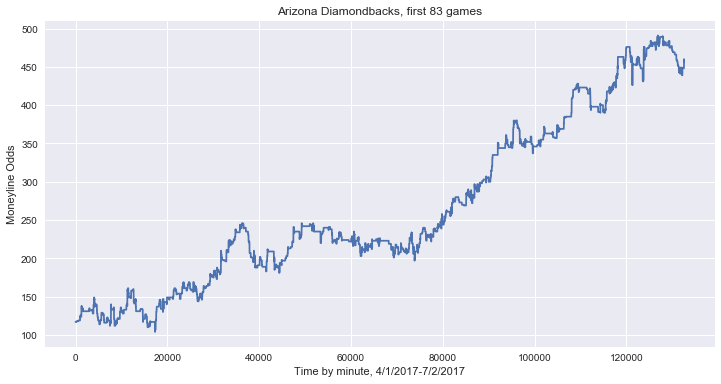

In [39]:
plt.figure(figsize=(12,6))
plt.plot(df_expand.Odds)
plt.title('Arizona Diamondbacks, first 83 games')
plt.ylabel("Moneyline Odds")
plt.xlabel('Time by minute, 4/1/2017-7/2/2017')